In [20]:
!python -V
!nvcc --version
!nvidia-smi

Python 3.7.11
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
Mon Aug 30 23:12:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                           

In [21]:
import string
import os
import re
import time
import math
import random
import gdown
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#plt.switch_backend('agg')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset

In [22]:
!ls
if os.path.isfile("data.zip"):
  print("file is already exist")
else:
  print("file is not here")
  !gdown --id '18xU5fsOjcowz83ea-2HWG6T6fK6qw-OW' --output data.zip #download data.zip
if os.path.isfile("train.txt"):
  print("file is already unzip")
else:
  print("unzip the file")
  !unzip -q data.zip


data.zip  drive  readme.txt  sample_data  test.txt  train.txt
file is already exist
file is already unzip


In [23]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "drive/MyDrive/NYCU/109 Summer Deep Learning and Practice/assignment/[Lab4] Conditional Sequence-to-Sequence VAE/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Test Unit

In [42]:
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
#compute BLEU-4 score
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33,0.33,0.33)
    else:
        weights = (0.25,0.25,0.25,0.25)
    return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)



def Gaussian_score(words):
    words_list = []
    score = 0
    yourpath = './train.txt'#should be your directory of train.txt
    with open(yourpath,'r') as fp:
        for line in fp:
            word = line.split(' ')
            word[3] = word[3].strip('\n')
            #print([word])
            words_list.extend([word])
        for t in words:
          for i in words_list:
            if t == i:
              score += 1
    return score/len(words)



In [25]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

#TextTransformer

In [26]:
SOS = 0
EOS = 1
PAD = 2
UNK = 3

class TextTransformer():
  def __init__(self):
    self.char2index = {"SOS":0, "EOS":1,"PAD":2, "UNK":3}
    self.index2char = {0:"SOS", 1:"EOS", 2:"PAD", 3:"UNK"}
    self.num_char = 4
    #self.char_count = {}
    
    all_letters = string.ascii_letters[0:26]
    for i in all_letters:
      self.addChar(i)

  def addChar(self, char):
    if char not in self.char2index:
      self.char2index[char] = self.num_char
      self.index2char[self.num_char] = char
      #self.char_count[char] = 1
      self.num_char += 1
    #else:
      #self.char_count[char] +=1
  
  def split_seq(self, seq):#split word to seq
    return [char for char in seq]

  def seq2indices(self, seq, add_SOS = False, add_EOS = False):
    seq = self.split_seq(seq)
    indices = []

    if add_SOS:
      indices.append(self.char2index["SOS"])

    for char in seq:
      if char in self.char2index:
        indices.append(self.char2index[char])
      else:
        indices.append(self.char2index["UNK"])
        
    if add_EOS:
      indices.append(self.char2index["EOS"])
    return indices

  def indices2seq(self, indices):
    seq = []
    for index in indices:
      if self.index2char[index] == "EOS":
        break
      else:
        if self.index2char[index] == "UNK" or self.index2char[index] =="SOS":
          pass
        else:
          seq.append(self.index2char[index])
    return seq

  def seq2word(self, seq):
    word = ""
    for char in seq:
      word += char
    return word


test = TextTransformer()
'''print(test.split_seq("hello"))
print(test.seq2indices(test.split_seq("hello"),True,True))
print(test.indices2seq(test.seq2indices(test.split_seq("hello"))))
print(test.seq2word(test.indices2seq(test.seq2indices(test.split_seq("hello")))))'''

'print(test.split_seq("hello"))\nprint(test.seq2indices(test.split_seq("hello"),True,True))\nprint(test.indices2seq(test.seq2indices(test.split_seq("hello"))))\nprint(test.seq2word(test.indices2seq(test.seq2indices(test.split_seq("hello")))))'

#Dataset

In [27]:
class TrainDataset(Dataset):
  def __init__(self):
    self.file_path = './train.txt'    
    self.datas = np.loadtxt(self.file_path,dtype=str)
    self.tence = ["sp","tp","pp","p"]#sp = simple-present, tp = third-present
                                     #pp present-progressive, p simple-past
    self.datas = np.reshape(self.datas,-1)
    self.text2tensor = TextTransformer()

  def __len__(self):
    return len(self.datas)

  def __getitem__(self,index):
    condition = index % len(self.tence)
    return self.text2tensor.seq2indices(self.datas[index],add_SOS=False,add_EOS=True), condition

class TestDataset(Dataset):
  def __init__(self):
    self.file_path = "./test.txt"
    self.datas = np.loadtxt(self.file_path,dtype=str)
    """sp -> p
       sp -> pg
       sp -> tp
       sp -> tp
       p  -> tp
       sp -> pg
       p  -> sp
       pg -> sp
       pg -> p
       pg -> tp"""
    self.condition =[[0,3],[0,2],[0,1],[0,1],[3,1],
                     [0,2],[3,0],[2,0],[2,3],[2,1]]
    self.datas = np.reshape(self.datas,(-1,2))
    self.text2tensor = TextTransformer()
  
  def __len__(self):
    return len(self.datas)

  def __getitem__(self,index):
    in_seq = self.text2tensor.seq2indices(self.datas[index][0],add_EOS=True)
    in_condi = self.condition[index][0]
    out_seq = self.text2tensor.seq2indices(self.datas[index][1],add_EOS=True)
    out_condi = self.condition[index][1]
    return in_seq, in_condi, out_seq, out_condi


#EncoderRNN

In [28]:

class EncoderRNN(nn.Module):
  def __init__(self, input_size, embedding_size=256, hidden_size=256,
               condi_size=4, condi_emb_size=8, latent_size=32, num_layer=1):
    super(EncoderRNN, self).__init__()
    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.condi_size = condi_size
    self.condi_emb_size = condi_emb_size
    self.latent_size = latent_size
    self.num_layer = num_layer

    self.embedding = nn.Embedding(self.input_size, self.embedding_size)
    self.condi_embedding = nn.Embedding(self.condi_size, self.condi_emb_size)
    
    self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layer)

    self.mean = nn.Linear(self.hidden_size, self.latent_size)
    self.logvar = nn.Linear(self.hidden_size, self.latent_size)

  def forward(self,input,hidden):
    input_embedding = self.embedding(input).view(1, 1, -1)

    output, hidden = self.lstm(input_embedding, hidden)

    mean_hidden = self.mean(hidden[0])
    logvar_hidden = self.logvar(hidden[0])

    z = self.reparameterization(mean_hidden, logvar_hidden)
    return output, hidden, z, mean_hidden, logvar_hidden
  
  def init_hidden(self, condition):
    condition_tensor = torch.LongTensor([condition]).to(device)
    condi_embedding = self.condi_embedding(condition_tensor).view(1, 1, -1)

    hidden = torch.randn(1, 1, (self.hidden_size - self.condi_emb_size)).to(device)
    hidden = torch.cat((hidden, condi_embedding),dim = 2)

    cell = torch.randn(1, 1, self.hidden_size)

    hidden = (hidden.to(device), cell.to(device))
    
    return hidden


  def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn(1, 1, self.latent_size, device=device) # sample a gaussain noise from N(0, I)
        z = mean + std * eps
        return z



#DecoderRNN

In [29]:
class DecoderRNN(nn.Module):
  def __init__(self, output_size, embedding_size=256, hidden_size=256,
               condi_size=4, condi_emb_size=8, latent_size=32, num_layer=1):
    super(DecoderRNN, self).__init__()
    self.output_size = output_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.condi_size = condi_size
    self.condi_emb_size = condi_emb_size
    self.latent_size = latent_size
    self.num_layer = num_layer

    self.latent_to_hidden = nn.Linear((self.latent_size + self.condi_emb_size), self.hidden_size)

    self.embedding = nn.Embedding(self.output_size, self.embedding_size)
    self.condi_embedding = nn.Embedding(self.condi_size, self.condi_emb_size)
    nn.init.normal_(self.embedding.weight, 0.0, 0.2)
    self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layer)
    self.out = nn.Linear(self.hidden_size, self.output_size)

  def forward(self, input, hidden):
    output_embedding = self.embedding(input).view(1, 1, -1)

    output = F.relu(output_embedding)

    output, hidden = self.lstm(output, hidden)

    output = self.out(output[0])

    return output, hidden

  def init_hidden(self, z, condition):
    condition_tensor = torch.LongTensor([condition]).to(device)
    condi_embedding = self.condi_embedding(condition_tensor).view(1, 1, -1)

    latent_hidden = torch.cat((z,condi_embedding), dim = 2)
    
    hidden = self.latent_to_hidden(latent_hidden)
    cell = torch.randn(1, 1, self.hidden_size)

    hidden = (hidden.to(device), cell.to(device))
    
    return hidden

#unit

In [30]:
def cal_KL_loss(mean, logvar):
  KL_loss = torch.sum(0.5 * (-logvar + (mean ** 2) + torch.exp(logvar) - 1))
  return KL_loss

def KL_Cost_Annealing(iter,  mode = 0):
  iter = iter
  
  if not mode: # mode = 0 is "monotonic"
    slope = 0.001
    w = slope * iter
    if w > 1.0:
      w = 1.0

  else: #mode = 1 is "cyclical"
    slope = 0.005
    period = 1.0 / slope * 2
    w = slope * (iter % period)
    if w > 1.0:
      w = 1.0

  return w

def Teacher_Forcing_Ratio(iter):
  slope =0.01
  level = 10
  w = 1.0 - (slope * (iter // level))
  if w <= 0.0:
    w = 0.0
  return w 

In [31]:
def show_noise(noise):
    plt.title('sample Z')
    plt.plot(noise.view(-1))
    plt.show()

In [32]:
def train(input, condition, traget, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion,
          KL_weight, teacher_forcing_rate):
  encoder.train()
  decoder.train()
  
  encoder_hidden = encoder.init_hidden(condition)

  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  loss = 0
  
  for ei in range(len(input)):
    output, encoder_hidden, z, e_maen, e_logvar = encoder(input[ei], encoder_hidden)

  KL_loss = cal_KL_loss(e_maen, e_logvar)

  decoder_input = torch.tensor([[SOS]], device=device)

  decoder_hidden = decoder.init_hidden(z, condition)

  use_teacher_forcing = True if random.random() < teacher_forcing_rate else False

  if use_teacher_forcing:
    for di in range(len(traget)):
      decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
      decoder_input = traget[di]
      loss += criterion(decoder_output, traget[di].view(-1))

  else:
    for di in range(len(traget)):
      decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
      top_value, top_index = decoder_output.topk(1)
      decoder_input = top_index.squeeze().detach()
      loss += criterion(decoder_output, traget[di].view(-1))

      if decoder_input.item() == EOS:
        break

  ((KL_weight * KL_loss)+loss).backward()

  encoder_optimizer.step()
  decoder_optimizer.step()

  return loss.item(), KL_loss.item()

#infer

In [33]:
def infer(encoder, decoder, in_seq, in_condi, out_seq, out_condi):

  with torch.no_grad():

    in_seq = torch.LongTensor(in_seq).to(device)
    encoder_hidden = encoder.init_hidden(in_condi)

    for ei in range(len(in_seq)):
      output, encoder_hidden, z, _, _ = encoder(in_seq[ei], encoder_hidden)

    decoder_input = torch.tensor([[SOS]], device=device)

    decoder_hidden = decoder.init_hidden(z.view(1, 1, -1), out_condi)

    output_word = []

    for di in range(len(out_seq)):
      decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

      top_value, top_index = decoder_output.topk(1)
      

      if top_index.item() == EOS:
        #output_word.append("EOS")
        break
      else:
        char = transformer.indices2seq([top_index.item()])
        if len(char)!=0:
          output_word.append(char[0])
      decoder_input = top_index.squeeze().detach()

    out_seq = transformer.seq2word(output_word)

    return out_seq

#score

In [34]:
def Cal_BLEU_4_score(encoder,decoder):
  with torch.no_grad():
    score = 0
    for in_seq, in_condi, out_seq, out_condi in testset:    
      decoder_output = infer(encoder, decoder, in_seq, in_condi, out_seq, out_condi)

      int_seq = transformer.seq2word((transformer.indices2seq(in_seq)))
      out_seq = transformer.seq2word((transformer.indices2seq(out_seq)))

      print("[input]:",int_seq,"[traget]:",out_seq,"[infer]:",decoder_output)
      score += compute_bleu(decoder_output,out_seq)

    score /= len(testset)
  return score

def Cal_Gaussian_score(decoder):

  words = Generate_gassian(decoder,num=100)

  return Gaussian_score(words)

def Generate_gassian(decoder, num):
  with torch.no_grad():

    words = []
    
    for i in range(num):
      string = []
      noise = torch.zeros(1, 1, latent_size) + (( 0.1**0.5 ) * torch.randn(1, 1, latent_size))

        
      for condition in range(4):
        decoder_hidden = decoder.init_hidden(noise.to(device),condition)
        decoder_input = torch.tensor([[SOS]], device=device)
        output_word = []
        
        for di in range(20):
          decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
          top_value, top_index = decoder_output.topk(1)
          
          if top_index.item() == EOS:
            #output_word.append("EOS")
            break

          else:
            char = transformer.indices2seq([top_index.item()])
            if len(char)!=0:
              output_word.append(char[0])
          decoder_input = top_index.squeeze().detach()
          out_seq = transformer.seq2word(output_word)
        string.append(out_seq)
      words.append(string)
  print(words)
  return words

#show image

In [35]:
def show_image(data, types, save=0,show=1):
  plt.figure()
  fig, ax = plt.subplots()
  loc = ticker.MultipleLocator(base=0.2)
  ax.yaxis.set_major_locator(loc)
  if types == "KL_loss":
    plt.plot(point, color="blue", linewidth=1)
    plt.xlabel("Iteration")
    plt.ylabel("KL_div_loss")
    plt.title("KL_div")
  elif types == "loss":
    plt.plot(point, color="blue", linewidth=1)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss")
  elif types == "BLEU":
    plt.plot(point, color="red", linewidth=1)
    plt.xlabel("Iteration")
    plt.ylabel("score")
    plt.title("BLEU score")
    plt.ylim(0.0,1.0)
  else:
    plt.plot(point, color="green", linewidth=1)
    plt.xlabel("Iteration")
    plt.ylabel("score")
    plt.title("Gaussian score")
  plt.legend()
  if show:
    plt.show()
  if not save:
    plt.savefig(str(types)+".png")

#save_load unit

In [36]:
def save_model(model,model_name):
  FILE = file_path + "model/" + str(model_name) + ".dict"
  torch.save(model.state_dict(), FILE)

def load_model(model,model_name):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  FILE = file_path + "monotonic/model/" + str(model_name) + ".dict"
  model.load_state_dict(torch.load(FILE))
  model.to(device)

#trainer

In [37]:
def trainer(encoder, decoder, epochs, learning_rate):
  start = time.time()
  best_score = 0
  if not os.path.isdir(file_path+"model"):
    os.mkdir(file_path+"model")

  f = open(file_path+'history.txt', 'w')
  f.close()

  losses = []
  KLD_loss = []
  Blue_scoce = []
  
  total_loss = 0
  total_KL_loss = 0
  
  Trainset = TrainDataset()
  Testset = TestDataset()

  criterion = nn.CrossEntropyLoss()
  encoder_optimizer=optim.SGD(encoder.parameters(), lr=learning_rate)
  decoder_optimizer=optim.SGD(decoder.parameters(), lr=learning_rate)

  for iter in range(epochs):
    print("iter:",iter)
    KL_weight = KL_Cost_Annealing(iter,mode=1)#mode 0 = monotonic mode 1 = cyclical
    teacher_forcing_rate = Teacher_Forcing_Ratio(iter)  

    for text, condition in Trainset:

      input = torch.LongTensor(text).to(device)
      traget = torch.LongTensor(text).to(device)
      
      loss, KL_loss = train(input, condition, traget, encoder, decoder,
                            encoder_optimizer, decoder_optimizer, criterion,
                            KL_weight, teacher_forcing_rate)

      total_loss += loss
      total_KL_loss += KL_loss

    loss_avg = total_loss / len(Trainset)
    KL_loss_avg = total_KL_loss / len(Trainset) 

    BLEU_4_score = Cal_BLEU_4_score(encoder,decoder)
    Gaussian_score = Cal_Gaussian_score(decoder)

    print('%s (%d %d%%): loss=%.4f, KL_loss=%.4f, BLEU_4_score=%.4f, Gaussian_score=%.4f'
              % (timeSince(start, (iter+1) / epochs), iter,
                 (iter+1) / epochs * 100, loss_avg,
                 KL_loss_avg, BLEU_4_score, Gaussian_score))

    f = open(file_path+'history.txt', 'a')
    f.write(str(iter) + ', ' + str(loss_avg) + ', ' + str(KL_loss_avg) + ', ' 
            + str(BLEU_4_score) + ', ' + str(Gaussian_score) + ', '
            + str(KL_weight) + ', ' + str(teacher_forcing_rate) + '\n')
    f.close()
    
    losses.append(loss_avg)
    KLD_loss.append(KL_loss_avg)

    if BLEU_4_score > best_score:
      best_score = BLEU_4_score
      save_path_encoder = file_path + '/model/' + 'encoder_epoch_' + str(iter) + '.dict'
      save_path_decoder = file_path + '/model/' + 'decoder_epoch_' + str(iter) + '.dict'
      torch.save(encoder.state_dict(), save_path_encoder)
      torch.save(decoder.state_dict(), save_path_decoder)

    total_loss = 0
    total_KL_loss = 0


#main

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
learning_rate=1e-3
epochs = 1000
latent_size = 64

transformer = TextTransformer()

trainset = TrainDataset()
testset = TestDataset()

encoder = EncoderRNN(30).to(device)
decoder = DecoderRNN(30).to(device)

criterion = nn.CrossEntropyLoss()
encoder_optimizer=optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer=optim.SGD(decoder.parameters(), lr=learning_rate)

#trainer(encoder,decoder,600,learning_rate)
load_model(encoder,"encoder_epoch_186")
load_model(decoder,"decoder_epoch_186")

BLEU_4_score = Cal_BLEU_4_score(encoder, decoder)
print(BLEU_4_score)

print(Cal_Gaussian_score(decoder))




[input]: abandon [traget]: abandoned [infer]: abandoned
[input]: abet [traget]: abetting [infer]: abetting
[input]: begin [traget]: begins [infer]: rings
[input]: expend [traget]: expends [infer]: expends
[input]: sent [traget]: sends [infer]: steats
[input]: split [traget]: splitting [infer]: splitting
[input]: flared [traget]: flare [infer]: flare
[input]: functioning [traget]: function [infer]: function
[input]: functioning [traget]: functioned [infer]: surveyed
[input]: healing [traget]: heals [infer]: hangs
0.6285692757956101
[['pritch', 'pritch', 'pritching', 'pritching'], ['stand', 'thind', 'hincing', 'think'], ['swoin', 'swoon', 'swoin', 'swoin'], ['flaring', 'flaring', 'flaring', 'flaring'], ['gaur', 'sweeping', 'sweep', 'sweep'], ['spemilling', 'spemilling', 'spemilling', 'spemin'], ['dipp', 'dip', 'dipping', 'dipping'], ['frigning', 'friek', 'frignated', 'frignated'], ['blowing', 'bolding', 'sweeping', 'sweeping'], ['flaunting', 'flaunting', 'sizing', 'flaunting'], ['profess

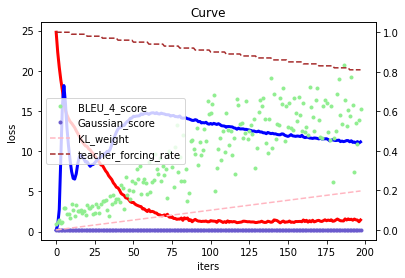

In [44]:
def read_and_show_curve(path):
    f = open(path, 'r')
    lines = f.readlines()
    f.close()
    iters = []
    loss_avg = []
    KL_loss_avg = []
    BLEU_4_score = []
    Gaussian_score = []
    KL_weight = []
    teacher_forcing_rate = []
    for index in range(len(lines)):
      x = re.split(", ", lines[index])
      iters.append(int(x[0]))
      loss_avg.append(float(x[1]))
      KL_loss_avg.append(float(x[2]))
      BLEU_4_score.append(float(x[3]))
      Gaussian_score.append(float(x[4]))
      KL_weight.append(float(x[5]))
      teacher_forcing_rate.append(float(x[6]))
      
    plt.figure()
    plt.title("Curve")
    plt.xlabel("iters")
    plt.ylabel("loss")

    plt.plot(iters, loss_avg, label="loss", linewidth=3, color="red")
    plt.plot(iters, KL_loss_avg, label="KL_loss", linewidth=3,color="blue")

    ax = plt.gca().twinx()

    ax.plot(iters, BLEU_4_score, ".", label="BLEU_4_score",color="lightgreen")
    ax.plot(iters, Gaussian_score, ".", label="Gaussian_score",color="slateblue")
    ax.plot(iters, KL_weight, "--", label="KL_weight",color="lightpink")
    ax.plot(iters, teacher_forcing_rate, "--", label="teacher_forcing_rate",color="brown")
    plt.legend()
    plt.show()

read_and_show_curve(file_path+"monotonic/"+'history.txt')